# IMPORT

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import torch.nn.functional as F
from itertools import chain

# DATA

In [256]:
corpus = [
    "You say goodbye and I say hello",
    "She says hello but he says goodbye",
    "They say goodbye and we say hello",
    "Hello and goodbye are words we often say",
    "I say hello to you and goodbye to them",
    "Goodbye is not forever and hello is not short",
    "When you say hello I feel happy",
    "I say hello and you say goodbye",
    "We always say hello before we say goodbye",
    "Saying goodbye is hard but saying hello is easy"
]

tokenzied_corpus = [sentence.split() for sentence in corpus]
vocab = set(chain(*tokenzied_corpus))
word_to_idx = {word : idx for idx, word in enumerate(vocab)}
idx_to_word = {idx : word for idx, word in enumerate(vocab)}

In [257]:
print(word_to_idx['I'])
print(idx_to_word[4])

11
not


# Hyperparameters

In [258]:
embedding_dim = 3
context_size = 1 # 앞 뒤 단어 개수

# Create Data

In [259]:
def generate_cbow_data(tokenized_corpus, context_size):
    data = []
    for sentence in tokenized_corpus:
        for i in range(context_size, len(sentence) - context_size):
            context = sentence[i - context_size : i] + sentence[i + 1 : i + 1 + context_size]
            target = sentence[i]
            data.append((context, target))
    return data

data = generate_cbow_data(tokenzied_corpus, context_size)
print(data[:2])

[(['You', 'goodbye'], 'say'), (['say', 'and'], 'goodbye')]


# Transform Data to Index

In [260]:
def context_to_idx(context, word_idx):
    return [word_to_idx[word] for word in context]

indexed_data = [(context_to_idx(context, word_to_idx), word_to_idx[target]) for context, target in data]

In [261]:
print(data[0])
print(indexed_data[0])

(['You', 'goodbye'], 'say')
([29, 12], 16)


# Model Define

In [279]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding_layer = nn.Linear(vocab_size, embedding_dim, bias=False)
        self.output_layer = nn.Linear(embedding_dim, vocab_size, bias=False)

    def forward(self, context_words):
        embeds = self.embedding_layer(context_words)
        mean_embeds = embeds.mean(dim=1)
        out = self.output_layer(mean_embeds)
        return out

# Prepare Train

In [295]:
vocab_size = len(vocab)
model = CBOW(vocab_size, embedding_dim)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# TRAIN

In [ ]:
for epoch in range(1500):
    total_loss = 0
    for context, target in indexed_data:
        context_tensor = torch.tensor([context], dtype=torch.long)
        context_tensor = F.one_hot(context_tensor, num_classes=vocab_size).float()
        
        target_tensor = torch.tensor([target], dtype=torch.long)
        #target_tensor = F.one_hot(target_tensor, num_classes=vocab_size).float()
    
        optimizer.zero_grad()
        output = model(context_tensor)
        
        loss = loss_function(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 204.3533
Epoch 100, Loss: 123.5646
Epoch 200, Loss: 98.2948
Epoch 300, Loss: 77.6734
Epoch 400, Loss: 63.4375
Epoch 500, Loss: 54.3676
Epoch 600, Loss: 48.6643
Epoch 700, Loss: 44.8317
Epoch 800, Loss: 42.0003
Epoch 900, Loss: 39.7165
Epoch 1000, Loss: 37.7418
Epoch 1100, Loss: 35.9934
Epoch 1200, Loss: 34.4862
Epoch 1300, Loss: 33.2244
Epoch 1400, Loss: 32.1764


# Visualization

In [275]:
word_embeddings = {}
for i, (word, idx) in enumerate(word_to_idx.items()):
    word_embeddings[word] = model.embedding_layer.weight[:, idx].detach().numpy()

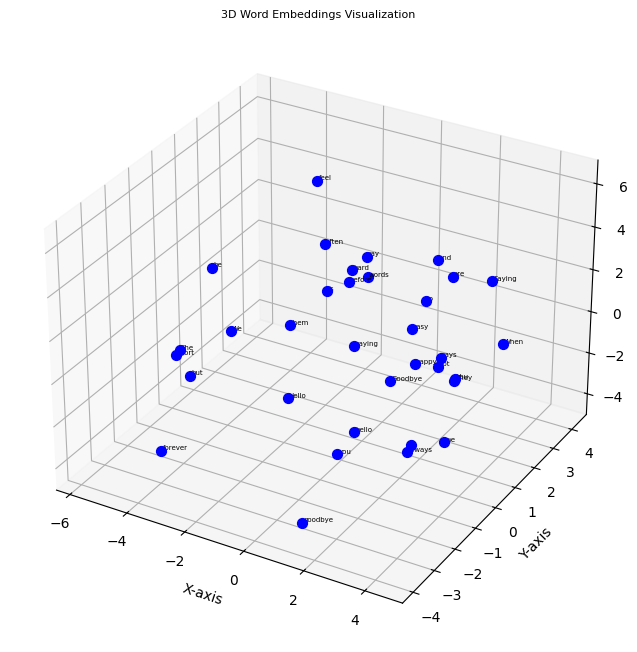

In [276]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 단어와 임베딩 벡터 분리
words = list(word_embeddings.keys())
embeddings = np.array(list(word_embeddings.values()))

# 3D 플롯 생성
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 각 단어의 임베딩 좌표를 3D 공간에 배치
for word, (x, y, z) in zip(words, embeddings):
    ax.scatter(x, y, z, marker='o', color='blue', s=50)
    ax.text(x + 0.02, y + 0.02, z + 0.02, word, fontsize=5)

# 축 레이블 설정
ax.set_title("3D Word Embeddings Visualization", fontsize=8)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()